In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set_style('whitgrid')
plt.style.use('ggplot')


%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

gender_submission.csv
new_knn.csv
new_lr.csv
new_randomForest.csv
new_svm.csv
new_tree.csv
submission.csv
test.csv
train.csv



Reference:
1. http://blog.csdn.net/han_xiaoyang/article/details/49797143
2. https://www.kaggle.com/startupsci/titanic-data-science-solutions?scriptVersionId=1145136

# Preprocessing the dataset

To preprocess the dataset, we need:
1. observe the dataset, check the type of each feature and the distribution of each feature
2. Observe the relation between the output label and the feature
3. Find the missing value and delete or add the missing value
4. According to the feature, considering to transform the features such as add the dimesions, etc.
5. Scaling if necessary
6. Preprocess the test dataset as well

In [2]:
# Read the dataset
gender_submission = pd.read_csv('../input/gender_submission.csv')
test = pd.read_csv('../input/test.csv')
train = pd.read_csv('../input/train.csv')

## Observe the dataset

In [3]:
# head of the trainining dataset
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
train.tail(5)

PassengerId  Survived  Pclass                                      Name  \
886          887         0       2                     Montvila, Rev. Juozas   
887          888         1       1              Graham, Miss. Margaret Edith   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   
889          890         1       1                     Behr, Mr. Karl Howell   
890          891         0       3                       Dooley, Mr. Patrick   

        Sex   Age  SibSp  Parch      Ticket   Fare Cabin Embarked  
886    male  27.0      0      0      211536  13.00   NaN        S  
887  female  19.0      0      0      112053  30.00   B42        S  
888  female   NaN      1      2  W./C. 6607  23.45   NaN        S  
889    male  26.0      0      0      111369  30.00  C148        C  
890    male  32.0      0      0      370376   7.75   NaN        Q

In [5]:
# print the information of the training dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
# print the distribution of the numerical features in the training dataset
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [7]:
# print the distribution of the categorical features in the training dataset
train.describe(include=['O'])

Name   Sex  Ticket Cabin Embarked
count                      891   891     891   204      889
unique                     891     2     681   147        3
top     Heikkinen, Miss. Laina  male  347082    G6        S
freq                         1   577       7     4      644

From the column information, wen can conclude two results:
1. the data type of each feature
2. there exists the missing value in the features, and some features even have more missing values than the normal values.
3. For Ticket and the Cabin, the frequency is too low , thus we ignore them for our baseline model.

Basically, there are around 11 columns except for the output label, so it is reasonable to select the features from these 11 columns for the baseline model at the beginning.

Here, I list several possible features here:

- Pclass
- Sex
- Age
- SibSp
- Parch
- Fare
- Embarked

We need to check the distribution of these features.

## Relation between the label and the feature
It is necessary to observe the relation between the output label and each feature to provide an initial observations.

### label and the numerical features
- age
- fare

#### Age

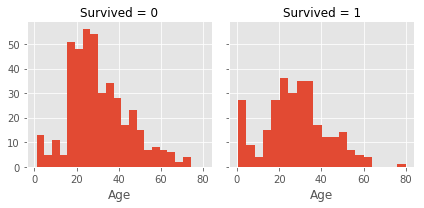

In [8]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(plt.hist, 'Age', bins=20)

#### Fare

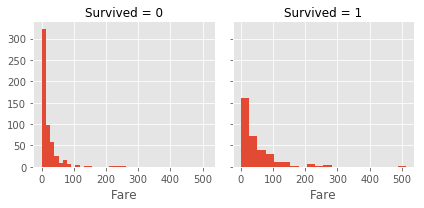

In [9]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(plt.hist, 'Fare', bins=20)

### label and the categorical features

- Pclass
- Sex
- SibSp
- Parch
- Embarked

#### Pclass

In [10]:
train[['Pclass', 'Survived']].groupby('Pclass').mean()

Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363

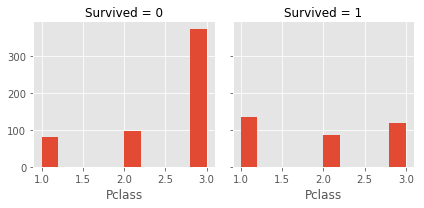

In [11]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(plt.hist, 'Pclass')

#### Sex

In [12]:
train[['Sex', 'Survived']].groupby('Sex').mean()

Survived
Sex             
female  0.742038
male    0.188908

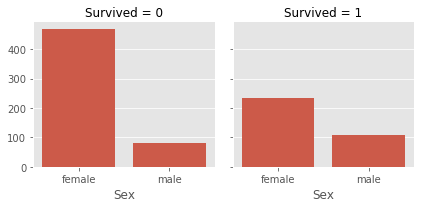

In [13]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(sns.countplot, 'Sex')

#### SibSp

In [14]:
train[['SibSp', 'Survived']].groupby('SibSp').mean()

Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000

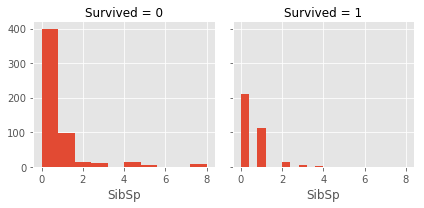

In [15]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(plt.hist, 'SibSp')

#### Parch

In [16]:
train[['Parch', 'Survived']].groupby('Parch').mean()

Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000

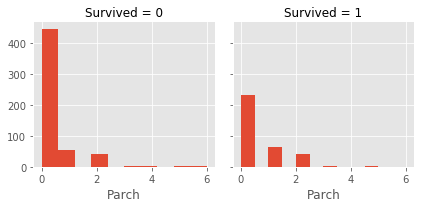

In [17]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(plt.hist, 'Parch')

#### Embarked

In [18]:
train[['Embarked', 'Survived']].groupby('Embarked').mean()

Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957

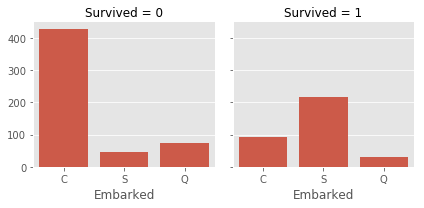

In [19]:
grid = sns.FacetGrid(train, col = 'Survived')
grid.map(sns.countplot, 'Embarked')

## Missing value
There are three columns have missing values:
- Cabin
- Age
- Embarked

Here, since we only take the 'Age' and the 'Embarked' as the features, we can ignore the feature 'Cabin' here for our baseline model.

When dealing with the missing values, we have two ways:
- Delete the corresponding record
- Estimate the missing value based on some other approaches such as the average value, the mode or some predictions.

Here, I use regression model to estimate the age, because I believe that the age is related to some other features like 'Pclass' and 'Parch'. For the 'Embarked', since there are only 2 records are missing, thus I will use the mode to estimate the missing value.

### Estimate the 'Embarked'

In [20]:
# fill the missing value with the mode value
mode = train['Embarked'].mode()
train.loc[train.Embarked.isnull(), 'Embarked'] = mode[0]
train.describe(include=['O'])

Name   Sex  Ticket Cabin Embarked
count                      891   891     891   204      891
unique                     891     2     681   147        3
top     Heikkinen, Miss. Laina  male  347082    G6        S
freq                         1   577       7     4      646

### Estimate the 'Age'

There are many different regression models I could choose for estimating the value, and I decided to use the random forest at the begining for the baseline model.

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Build the random forest regressor to estimate the age
def Estimate_Age(df):
    dataset = df[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]
    
    known_age = dataset[dataset.Age.notnull()].as_matrix()
    unknown_age = dataset[dataset.Age.isnull()].as_matrix()
    
    X = known_age[:, 1:]
    y = known_age[:, 0]
    
    regr = RandomForestRegressor(n_estimators = 1000, random_state = 0)
    regr.fit(X, y)
    
    estimate_age = regr.predict(unknown_age[:, 1:])
    train.loc[train.Age.isnull(), 'Age'] = estimate_age

    return train, regr

In [22]:
train_set, regr_age = Estimate_Age(train)
train_set.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.645386    0.523008   
std     257.353842    0.486592    0.836071   13.630966    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.000000    0.000000   
50%     446.000000    0.000000    3.000000   29.000000    0.000000   
75%     668.500000    1.000000    3.000000   36.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

## Transforming features

Here, we use the logistic regression as the baseline model and we need to transform the features like 'Embarked' into features with numbers.

- Pclass
- Sex
- Embarked

### Pclass
The value of 'Pclass' is 1, 2, 3, thus we can convert the feature 'Pclass' into a feature with 3 dimensions (or 3 features):
- Pclass_1
- Pclass_2
- Pclass_3

### Sex
- Sex_female
- Sex_male

### Embarked
- Embarked_S
- Embarked_Q
- Embarked_C

In [23]:
def Transform_Feature(df):
    Pclass_dummies = pd.get_dummies(df['Pclass'], prefix = 'Pclass')
    Sex_dummies = pd.get_dummies(df['Sex'], prefix = 'Sex')
    Embarked_dummies = pd.get_dummies(df['Embarked'], prefix = 'Embarked')

    df = pd.concat([df, Pclass_dummies, Sex_dummies, Embarked_dummies], axis=1)
#     df.drop(['Pclass', 'Sex', 'Embarked', 'Cabin', 'Name', 'Ticket'], inplace=True, axis=1)
    return df

In [24]:
train = Transform_Feature(train_set)
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  Pclass_1  Pclass_2  \
0      0         A/5 21171   7.2500   NaN        S         0         0   
1      0          PC 17599  71.2833   C85        C         1         0   
2      0  STON/O2. 3101282   7.9250   NaN        S         0         0   
3      0            113803  53.1000  C123        S         1         0   
4      0            373450   8.0500   NaN        S         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           0           1  
1         0           1         0           1           0           0  
2         1           1         0           0           0           1  
3         0           1         0           0           0           1  
4         1           0         1           0           0           1

## Scaling

There are four features need to be scaled:
- Age
- SibSp
- Parch
- Fare

Here, we will use the scaling methods from sklearn.

The reason we use standardscaler instead of scale in sklearn is that we can use the standardscaler to transform the test data according to the training data.

In [25]:
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
scale_param = scaler.fit(train[['Age', 'SibSp', 'Parch', 'Fare']].values)
scaled_features = scaler.fit_transform(train[['Age', 'SibSp', 'Parch', 'Fare']].values, scale_param)
train[['Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']] = pd.DataFrame(scaled_features, index=train.index)
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare     ...      Pclass_3 Sex_female  \
0      0         A/5 21171   7.2500     ...             1          0   
1      0          PC 17599  71.2833     ...             0          1   
2      0  STON/O2. 3101282   7.9250     ...             1          1   
3      0            113803  53.1000     ...             0          1   
4      0            373450   8.0500     ...             1          0   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  Age_scaled  SibSp_scaled  \
0         1           0           0           1   -0.561199      0.432793   
1         0           1           0           0    0.613259      0.432793   
2         0           0           0           1   -0.267584     -0.474545   
3         0           0           0           1    0.393048      0.432793   
4         1           0           0           1    0.393048     -0.474545   

   Parch_scaled  Fare_scaled  
0     -0.473674    -0.502445  
1     -0.473674     0.786845  
2     -0.473674    -0.488854  
3     -0.473674     0.420730  
4     -0.473674    -0.486337  

[5 rows x 24 columns]

## Preprocess the test set
1. Observe the original test set
2. Add the missing value
3. Transform the categorical features
4. Scaling some numerical features

### Observe the test set

In [26]:
# Check the test set
test.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

In [27]:
test.describe(include=['O'])

Name   Sex    Ticket            Cabin Embarked
count                    418   418       418               91      418
unique                   418     2       363               76        3
top     Vartanian, Mr. David  male  PC 17608  B57 B59 B63 B66        S
freq                       1   266         5                3      270

### Add estimated features
According to the observation, for the selected features, we need to add the estimated value for the features 'Age' and 'Fare'. Here we all use the Random Forest Regression model trained from the training set to estimate.

#### Estimate Fare
There is only one record that doesn't have the value of 'Fare'. To make the process easier, we decided to use the mean value

In [28]:
test.loc[test.Fare.isnull(), 'Fare'] = train.Fare.mean()

#### Estimate Age
We use the regression model obtained from the training set to predict the missing age in the test set.

In [29]:
df= test[['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']]
unknown_age = df[df.Age.isnull()].as_matrix()
estimated_age = regr_age.predict(unknown_age[:, 1:])
test.loc[test.Age.isnull(), 'Age'] = estimated_age
test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

### Transform the categorical features
- Pclass
- Sex
- Embarked

In [30]:
test = Transform_Feature(test)
test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Pclass_1  Pclass_2  \
0  34.5      0      0   330911   7.8292   NaN        Q         0         0   
1  47.0      1      0   363272   7.0000   NaN        S         0         0   
2  62.0      0      0   240276   9.6875   NaN        Q         0         1   
3  27.0      0      0   315154   8.6625   NaN        S         0         0   
4  22.0      1      1  3101298  12.2875   NaN        S         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           1           0  
1         1           1         0           0           0           1  
2         0           0         1           0           1           0  
3         1           0         1           0           0           1  
4         1           1         0           0           0           1

### Scaling the features
Scale the features:
- Age
- SibSp
- Parch
- Fare

In [31]:
scaled_features = scaler.fit_transform(test[['Age', 'SibSp', 'Parch', 'Fare']].values, scale_param)
test[['Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']] = pd.DataFrame(scaled_features, index=test.index)
test.head(5)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin     ...      Pclass_3  \
0  34.5      0      0   330911   7.8292   NaN     ...             1   
1  47.0      1      0   363272   7.0000   NaN     ...             1   
2  62.0      0      0   240276   9.6875   NaN     ...             0   
3  27.0      0      0   315154   8.6625   NaN     ...             1   
4  22.0      1      1  3101298  12.2875   NaN     ...             1   

   Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Age_scaled  \
0           0         1           0           1           0    0.307397   
1           1         0           0           0           1    1.255839   
2           0         1           0           1           0    2.393970   
3           0         1           0           0           1   -0.261669   
4           1         0           0           0           1   -0.641046   

   SibSp_scaled  Parch_scaled  Fare_scaled  
0     -0.499470     -0.400248    -0.498258  
1      0.616992     -0.400248    -0.513125  
2     -0.499470     -0.400248    -0.464940  
3     -0.499470     -0.400248    -0.483317  
4      0.616992      0.619896    -0.418323  

[5 rows x 23 columns]

# Baseline model
Here we use the logisitic regression model for classification.

There are several steps we can do here:
1. Build the baseline model and submit the result to Kaggle
2. Observe the coefficient of each feature
3. Observe the bad case
4. Considering the new features based on the observation

## Build the baseline model

In [32]:
# build the dataset
from sklearn.linear_model import LogisticRegression
train_data = train[['Survived', 'Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
test_data = test[['Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]

In [33]:
train_data.head(5)

Survived  Age_scaled  SibSp_scaled  Parch_scaled  Fare_scaled  Pclass_1  \
0         0   -0.561199      0.432793     -0.473674    -0.502445         0   
1         1    0.613259      0.432793     -0.473674     0.786845         1   
2         1   -0.267584     -0.474545     -0.473674    -0.488854         0   
3         1    0.393048      0.432793     -0.473674     0.420730         1   
4         0    0.393048     -0.474545     -0.473674    -0.486337         0   

   Pclass_2  Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
0         0         1           0         1           0           0   
1         0         0           1         0           1           0   
2         0         1           1         0           0           0   
3         0         0           1         0           0           0   
4         0         1           0         1           0           0   

   Embarked_S  
0           1  
1           0  
2           1  
3           1  
4           1

In [34]:
test_data.head(5)

Age_scaled  SibSp_scaled  Parch_scaled  Fare_scaled  Pclass_1  Pclass_2  \
0    0.307397     -0.499470     -0.400248    -0.498258         0         0   
1    1.255839      0.616992     -0.400248    -0.513125         0         0   
2    2.393970     -0.499470     -0.400248    -0.464940         0         1   
3   -0.261669     -0.499470     -0.400248    -0.483317         0         0   
4   -0.641046      0.616992      0.619896    -0.418323         0         0   

   Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0         1           0         1           0           1           0  
1         1           1         0           0           0           1  
2         0           0         1           0           1           0  
3         1           0         1           0           0           1  
4         1           1         0           0           0           1

In [35]:
# train the model
X_train, Y_train = train_data.as_matrix()[:, 1:], train_data.as_matrix()[:, 0]
X_test = test_data.as_matrix()
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [36]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/submission.csv', index=False)

The accuracy for the baseline model is 75.598% and it's time to improve it!

## Observe the coefficient of the features

In [37]:
pd.DataFrame({'features': list(train_data.columns)[1:], 'coef': list(clf.coef_.T)})

coef      features
0    [-0.532140275127]    Age_scaled
1    [-0.386615390101]  SibSp_scaled
2   [-0.0717805927193]  Parch_scaled
3     [0.099065801058]   Fare_scaled
4      [1.00077273033]      Pclass_1
5                [0.0]      Pclass_2
6     [-1.23374553271]      Pclass_3
7        [1.786530935]    Sex_female
8    [-0.863327475539]      Sex_male
9                [0.0]    Embarked_C
10               [0.0]    Embarked_Q
11   [-0.377176705952]    Embarked_S

According to the above table, there is no group of features whos coefficients are closed to zero. Thus, I decided to keep all of these features (If the coefficient of 'Embarked_S' is very closed to zero as well, I might consider to remove the features like 'Embarked_C', 'Embarked_Q', and 'Embarked_S').

## Observe the bad case
1. Split the training data into two parts: training set and validation set.
2. Predict the result of the validation set and check the bad case in the validation set.

In [38]:
# split the data
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(train, test_size=0.4, random_state=0)
train_data = training_set[['Survived', 'Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
validation_data = validation_set[['Survived', 'Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]

In [39]:
# train the model and predict the validation set
X_train, Y_train = train_data.as_matrix()[:, 1:], train_data.as_matrix()[:, 0]
X_validation, Y_validation = validation_data.as_matrix()[:, 1:], validation_data.as_matrix()[:, 0]
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_validation)
bad_case = validation_set.loc[validation_set.PassengerId.isin(validation_set[Y_pred != validation_data.as_matrix()[:, 0]]['PassengerId'].values)]
bad_case.head(10)

PassengerId  Survived  Pclass                                  Name  \
298          299         1       1                 Saalfeld, Mr. Adolphe   
14            15         0       3  Vestrom, Miss. Hulda Amanda Adolfina   
803          804         1       3       Thomas, Master. Assad Alexander   
474          475         0       3           Strandberg, Miss. Ida Sofia   
642          643         0       3         Skoog, Miss. Margit Elizabeth   
55            56         1       1                     Woolner, Mr. Hugh   
587          588         1       1      Frolicher-Stehli, Mr. Maxmillian   
740          741         1       1           Hawksford, Mr. Walter James   
839          840         1       1                  Marechal, Mr. Pierre   
301          302         1       3                    McCoy, Mr. Bernard   

        Sex        Age  SibSp  Parch  Ticket     Fare     ...      Pclass_3  \
298    male  41.737485      0      0   19988  30.5000     ...             0   
14   female  14.000000      0      0  350406   7.8542     ...             1   
803    male   0.420000      0      1    2625   8.5167     ...             1   
474  female  22.000000      0      0    7553   9.8375     ...             1   
642  female   2.000000      3      2  347088  27.9000     ...             1   
55     male  44.103245      0      0   19947  35.5000     ...             0   
587    male  60.000000      1      1   13567  79.2000     ...             0   
740    male  38.459054      0      0   16988  30.0000     ...             0   
839    male  50.922517      0      0   11774  29.7000     ...             0   
301    male  23.315126      2      0  367226  23.2500     ...             1   

    Sex_female  Sex_male  Embarked_C  Embarked_Q  Embarked_S  Age_scaled  \
298          0         1           0           0           1    0.887603   
14           1         0           0           0           1   -1.148427   
803          0         1           1           0           0   -2.145248   
474          1         0           0           0           1   -0.561199   
642          1         0           0           0           1   -2.029270   
55           0         1           0           0           1    1.061259   
587          0         1           1           0           0    2.228137   
740          0         1           0           0           1    0.646955   
839          0         1           1           0           0    1.561817   
301          0         1           0           1           0   -0.464664   

     SibSp_scaled  Parch_scaled  Fare_scaled  
298     -0.474545     -0.473674    -0.034314  
14      -0.474545     -0.473674    -0.490280  
803     -0.474545      0.767630    -0.476941  
474     -0.474545     -0.473674    -0.450347  
642      2.247470      2.008933    -0.086664  
55      -0.474545     -0.473674     0.066360  
587      0.432793      0.767630     0.946246  
740     -0.474545     -0.473674    -0.044381  
839     -0.474545     -0.473674    -0.050421  
301      1.340132     -0.473674    -0.180290  

[10 rows x 24 columns]

In [40]:
bad_case.describe()

PassengerId   Survived     Pclass        Age      SibSp      Parch  \
count    71.000000  71.000000  71.000000  71.000000  71.000000  71.000000   
mean    419.338028   0.619718   2.422535  27.295469   0.563380   0.521127   
std     262.427565   0.488911   0.856271  14.960223   0.937053   0.968934   
min      15.000000   0.000000   1.000000   0.420000   0.000000   0.000000   
25%     199.500000   0.000000   2.000000  18.500000   0.000000   0.000000   
50%     403.000000   1.000000   3.000000  25.000000   0.000000   0.000000   
75%     643.500000   1.000000   3.000000  35.144650   1.000000   1.000000   
max     886.000000   1.000000   3.000000  63.000000   4.000000   5.000000   

             Fare   Pclass_1   Pclass_2   Pclass_3  Sex_female   Sex_male  \
count   71.000000  71.000000  71.000000  71.000000   71.000000  71.000000   
mean    27.347007   0.239437   0.098592   0.661972    0.394366   0.605634   
std     35.619402   0.429777   0.300235   0.476405    0.492193   0.492193   
min      0.000000   0.000000   0.000000   0.000000    0.000000   0.000000   
25%      8.327100   0.000000   0.000000   0.000000    0.000000   0.000000   
50%     15.245800   0.000000   0.000000   1.000000    0.000000   1.000000   
75%     29.062500   0.000000   0.000000   1.000000    1.000000   1.000000   
max    247.520800   1.000000   1.000000   1.000000    1.000000   1.000000   

       Embarked_C  Embarked_Q  Embarked_S  Age_scaled  SibSp_scaled  \
count   71.000000   71.000000   71.000000   71.000000     71.000000   
mean     0.225352    0.084507    0.690141   -0.172492      0.036631   
std      0.420788    0.280126    0.465727    1.098134      0.850224   
min      0.000000    0.000000    0.000000   -2.145248     -0.474545   
25%      0.000000    0.000000    0.000000   -0.818111     -0.474545   
50%      0.000000    0.000000    1.000000   -0.340988     -0.474545   
75%      0.000000    0.000000    1.000000    0.403666      0.432793   
max      1.000000    1.000000    1.000000    2.448348      3.154809   

       Parch_scaled  Fare_scaled  
count     71.000000    71.000000  
mean       0.173203    -0.097798  
std        1.202741     0.717186  
min       -0.473674    -0.648422  
25%       -0.473674    -0.480758  
50%       -0.473674    -0.341452  
75%        0.767630    -0.063257  
max        5.732844     4.335332

## New features

There are several features needed to be added into the model and some features should be removed.

Features needed to be added:
- Title
- Family Size
- IsAlone
- AgeBand

### Add Title

In [41]:
train['Title'] = train_set.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train['Title'], train['Survived'])

Survived    0    1
Title             
Capt        1    0
Col         1    1
Countess    0    1
Don         1    0
Dr          4    3
Jonkheer    1    0
Lady        0    1
Major       1    1
Master     17   23
Miss       55  127
Mlle        0    2
Mme         0    1
Mr        436   81
Mrs        26   99
Ms          0    1
Rev         6    0
Sir         0    1

In [42]:
from collections import defaultdict
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Miss')

tmpDict = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4}
TitleDict = defaultdict(lambda: 5, tmpDict)
train['Title'] = train['Title'].map(TitleDict)
train['Title'] = train['Title'].fillna(0)

### Add family size
FamilySize = SibSp + Parch

In [43]:
train['FamilySize'] = train['SibSp'] + train['Parch']

### Add IsAlone
- IsAlone = 1 if FamilySize = 0
- IsAlone = 0 if FamilySize > 0

In [44]:
train['IsAlone'] = (train['FamilySize'] == 0)

### AgeBand
According to other solutions, the age are often divided into 5 groups, that's what we are going to do.

In [45]:
train['AgeBand'] = pd.cut(train['Age'], 5, labels=[1, 2, 3, 4, 5])

# Improve the model
To improve the model, we have several steps to do:
1. Transform and scaling the new features
2. Preprocess the test set
3. Run new models like random forests, decision tree, knn as well as the LR model
4. Check the learning curve of these models to confirm that there is no overfitting
5. Model ensemble

## Preprocess the new features
### Transform the new features
The features needed to be transformed:
- Title
- IsAlone
- AgeBand

In [46]:
def new_transform(df):
    Title_dummies = pd.get_dummies(df['Title'], prefix = 'Title')
    IsAlone_dummies = pd.get_dummies(df['IsAlone'], prefix = 'IsAlone')
    AgeBand_dummies = pd.get_dummies(df['AgeBand'], prefix = 'AgeBand')

    df = pd.concat([df, Title_dummies, IsAlone_dummies, AgeBand_dummies], axis=1)
#     df.drop(['Title', 'IsAlone', 'AgeBand'], inplace=True, axis=1)
    return df

In [47]:
train = new_transform(train)

### Scale the new features

New feature: FamilySize

In [48]:
scaler = preprocessing.StandardScaler()
scale_param = scaler.fit(train[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']].values)
scaled_features = scaler.fit_transform(train[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']].values, scale_param)
train[['Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'FamilySize_scaled']] = pd.DataFrame(scaled_features, index=train.index)
# train.drop(['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize'], inplace=True, axis=1)
train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare        ...         Title_4 Title_5  \
0      0         A/5 21171   7.2500        ...               0       0   
1      0          PC 17599  71.2833        ...               0       0   
2      0  STON/O2. 3101282   7.9250        ...               0       0   
3      0            113803  53.1000        ...               0       0   
4      0            373450   8.0500        ...               0       0   

   IsAlone_False  IsAlone_True  AgeBand_1  AgeBand_2  AgeBand_3  AgeBand_4  \
0              1             0          0          1          0          0   
1              1             0          0          0          1          0   
2              0             1          0          1          0          0   
3              1             0          0          0          1          0   
4              0             1          0          0          1          0   

   AgeBand_5  FamilySize_scaled  
0          0           0.059160  
1          0           0.059160  
2          0          -0.560975  
3          0           0.059160  
4          0          -0.560975  

[5 rows x 41 columns]

Now we have 36 features in total for each record, and it's time to rerun the model and predict the test result again. But we also need to preprocess the test dataset at first.

## Preprocess the test set

### Add new features for test set
- Title
- Family Size
- IsAlone
- AgeBand

In [49]:
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].map(TitleDict)
test['Title'] = test['Title'].fillna(0)
test['FamilySize'] = test['SibSp'] + test['Parch']
test['IsAlone'] = (test['FamilySize'] == 0)
test['AgeBand'] = pd.cut(test['Age'], 5, labels=[1, 2, 3, 4, 5])

### Transform the new features of the test set

In [50]:
test = new_transform(test)

### Scale the new features of the test set

In [51]:
scaled_features = scaler.fit_transform(test[['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']].values, scale_param)
test[['Age_scaled', 'SibSp_scaled', 'Parch_scaled', 'Fare_scaled', 'FamilySize_scaled']] = pd.DataFrame(scaled_features, index=test.index)

## Run the models with additional features
- Logistic Regression
- Random Forest
- Knn
- SVM
- Decision Tree

### Logistic Regression
- Train the model
- Predict the result
- Learning Curve

In [52]:
# build the dataset from the complete dataset
train_data = train.filter(regex='Survived|Age_.*|SibSp_.*|Parch_.*|Fare_.*|FamilySize_.*|Pclass_.*|Embarked_.*|Sex_.*|Title_.*|IsAlone_.*|AgeBand_.*')
test_data = test.filter(regex='Age_.*|SibSp_.*|Parch_.*|Fare_.*|FamilySize_.*|Pclass_.*|Embarked_.*|Sex_.*|Title_.*|IsAlone_.*|AgeBand_.*')
X_train, Y_train = train_data.as_matrix()[:, 1:], train_data.as_matrix()[:, 0]
X_test = test_data.as_matrix()

In [53]:
# train the model
clf = LogisticRegression(penalty='l1')
clf.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/new_lr.csv', index=False)

The accuracy in Kaggle.com is 77.51%. Now we need to draw the learning curve to make sure there is no overfitting.

In [55]:
# Learning curve
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, X, y, train_sizes):
    train_sizes, train_scores, validation_scores = learning_curve(estimator, X, y, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return train_sizes, train_scores, validation_scores

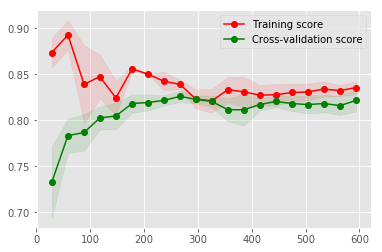

In [56]:
train_sizes, train_scores, validation_scores = plot_learning_curve(LogisticRegression(penalty='l1'), X_train, Y_train, np.linspace(.05, 1., 20))

### Random Forest
- Train the model
- Predict the result
- Learning Curve

In [57]:
# train the model
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [58]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/new_randomForest.csv', index=False)

The accuracy in Kaggle.com is 0.75598. Now we need to draw the learning curve to make sure there is no overfitting.

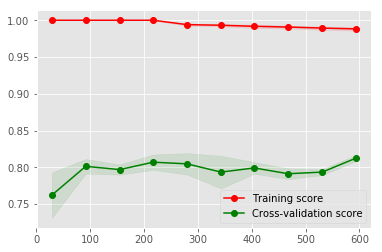

In [59]:
# Learning curve
train_sizes, train_scores, validation_scores = plot_learning_curve(RandomForestClassifier(n_estimators=100), X_train, Y_train, np.linspace(.05, 1., 10))

Overfitting is much more obvious than that of the random forest.

### knn model
- Train the model
- Predict the result
- Learning Curve

In [60]:
# train the model
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [61]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/new_knn.csv', index=False)

The accuracy in Kaggle.com is 0.74162

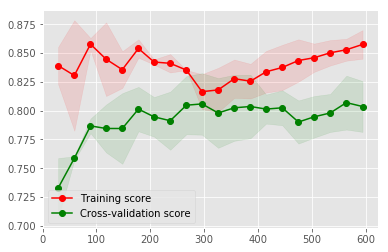

In [62]:
# Learning curve
train_sizes, train_scores, validation_scores = plot_learning_curve(KNeighborsClassifier(n_neighbors=5), X_train, Y_train, np.linspace(.05, 1., 20))

### Support Vector Machine
- Train the model
- Predict the result
- Learning Curve

In [63]:
# train the model
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [64]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/new_svm.csv', index=False)

The accuracy in Kaggle.com is 0.78947

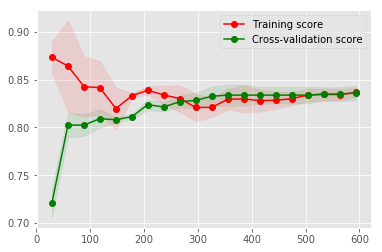

In [65]:
# Learning curve
train_sizes, train_scores, validation_scores = plot_learning_curve(svm.SVC(), X_train, Y_train, np.linspace(.05, 1., 20))

### Decision Tree
- Train the model
- Predict the result
- Learning Curve

In [66]:
# train the model
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [67]:
# predict the result of the test set
Y_test = clf.predict(X_test)
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# result.to_csv('../input/new_tree.csv', index=False)

The accuracy in Kaggle.com is 0.74162

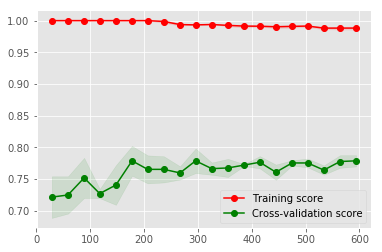

In [68]:
# Learning curve
train_sizes, train_scores, validation_scores = plot_learning_curve(tree.DecisionTreeClassifier(), X_train, Y_train, np.linspace(.05, 1., 20))

Decision tree and the random forest all cause the overfitting easily.

## Model ensemble

After checking the learning curve and comparing the prediction result, knn, logistic regression and svm are selected to predict the labels together by voting.

In [72]:
# lr model
lr_clf = LogisticRegression(penalty='l1')
lr_clf.fit(X_train, Y_train)
Y_test = lr_clf.predict(X_test)
lr_result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# knn model
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, Y_train)
Y_test = knn_clf.predict(X_test)
knn_result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# svm model
svm_clf = svm.SVC()
svm_clf.fit(X_train, Y_train)
Y_test = svm_clf.predict(X_test)
svm_result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})

# random forest
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train, Y_train)
Y_test = rf_clf.predict(X_test)
rf_result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})
# decision tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(X_train, Y_train)
Y_test = dt_clf.predict(X_test)
dt_result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(), 'Survived': Y_test.astype(np.int32)})

In [73]:
# voting predict
result = pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix()})
result['Survived_Vote'] = lr_result['Survived'] + knn_result['Survived'] + svm_result['Survived'] + rf_result['Survived'] + dt_result['Survived']
result['Survived'] = result['Survived_Vote'].apply(lambda x: 1 if x > 2 else 0)
result.drop(['Survived_Vote'], inplace=True, axis=1)
result.to_csv("../input/voting.csv", index=False)

The accuracy of the voting model with 3 or 5 models in Kaggle.com are both 0.78468